# word2vec (CBOW)

## 1.Load data

### import library

In [1]:
import numpy as np 
import torch 
import torch.nn as nn
import torch.optim as optim 
import matplotlib.pyplot as plt 
import spacy
import pandas as pd 
import time 
import itertools
nlp = spacy.load("en_core_web_sm")

### Load corpus data from CSV File

In [2]:
df = pd.read_csv('corpus.csv')
all_text = df.text

## 2.Tokenization

In [3]:
corpus_tokenized_str = []
for doc in all_text :
    for token in nlp(doc) : #Tokenize data
        corpus_tokenized_str.append(str(token))


In [4]:
corpus_tokenized_str[:10] # Show 10 example of tokenized data

[' ', 'Stuning', 'even', 'for', 'the', 'non', '-', 'gamer', ':', 'This']

In [5]:
vocabs = list(set(corpus_tokenized_str))
vocabs[:10]

['focused',
 'fireballing',
 'tag',
 "'d",
 'revengeful',
 'structure',
 'remember',
 'embarrassed',
 'feat',
 'Captain']

## 3.Numerization

In [6]:
word_2_idx = {v: idx for idx, v in enumerate(vocabs)}

In [7]:
print(word_2_idx["fun"]) #Check index of word "fun"

746


In [8]:
vocabs.append('<UNK>')
word_2_idx['<UNK>'] = len(word_2_idx) 

In [9]:
dict(itertools.islice(word_2_idx.items(), 10))

{'focused': 0,
 'fireballing': 1,
 'tag': 2,
 "'d": 3,
 'revengeful': 4,
 'structure': 5,
 'remember': 6,
 'embarrassed': 7,
 'feat': 8,
 'Captain': 9}

## 4.Prepare data

In [10]:
def random_batch(batch_size, corpus):
    
    CBOW = []

    #for each corpus
    for sent in corpus_tokenized_str:
        try :
            for i in range(2, len(sent) - 2): #start from 1 to second last
                center_word = word_2_idx[sent[i]]
                outside_words = [word_2_idx[sent[i-2]], word_2_idx[sent[i-1]], word_2_idx[sent[i+1]], word_2_idx[sent[i+2]]]  #window_size = 2
                for o in outside_words:
                    CBOW.append([o, center_word])
        except :
            pass               
    #only get a batch, not the entire list
    random_inputs, random_labels = [], []   
    random_index = np.random.choice(range(len(CBOW)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    for index in random_index:
        random_inputs.append([CBOW[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([CBOW[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

## 5.Model

In [11]:
voc_size = len(vocabs) #Size of vocabs

In [12]:
class NLP_model(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(NLP_model, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size, 1)
        #all_vocabs: (batch_size, voc_size)
        
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term)  #exp(uo vc)
        #(batch_size, 1)
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) #sum exp(uw vc)
        #(batch_size, 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        #(batch_size, 1) / (batch_size, 1) ==mean==> scalar
        
        return loss_fn

## 6.Train

In [13]:
batch_size = 2 # Batch size 
emb_size   = 2 #Embeading size of 2
model      = NLP_model(voc_size, emb_size)

criterion  = nn.CrossEntropyLoss()  #-log
optimizer  = optim.Adam(model.parameters(), lr=0.000123)

In [14]:

def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word_2_idx).expand(batch_size, voc_size)
all_vocabs.shape #Shape of vocabs

torch.Size([2, 1600])

In [15]:
def epoch_time(start_time, end_time):
    elapsed_time = (end_time - start_time)
    return elapsed_time

In [16]:
num_epochs = 10000
run_time_normal = 0
#for epoch
for epoch in range(num_epochs):
    start_time = time.time()

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized_str)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = model
    loss = model(input_batch, label_batch, all_vocabs)
    #backpropagate
    loss.backward()
    #update alpha
    optimizer.step()
    stop_time = time.time()
    run_time_normal = run_time_normal + epoch_time(start_time, stop_time)
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {run_time_normal} s")

Epoch 1000 | Loss: 6.507854 | Time: 4.149869918823242 s
Epoch 2000 | Loss: 4.611245 | Time: 7.901148557662964 s
Epoch 3000 | Loss: 4.819673 | Time: 11.592925548553467 s
Epoch 4000 | Loss: 5.041370 | Time: 15.28419542312622 s
Epoch 5000 | Loss: 4.586281 | Time: 19.162463903427124 s
Epoch 6000 | Loss: 3.627839 | Time: 22.91574239730835 s
Epoch 7000 | Loss: 3.635268 | Time: 26.565000772476196 s
Epoch 8000 | Loss: 3.225784 | Time: 30.19426465034485 s
Epoch 9000 | Loss: 5.452096 | Time: 33.94054675102234 s
Epoch 10000 | Loss: 2.551394 | Time: 37.59581804275513 s


In [17]:
def get_embed(word):
    try:
        index = word_2_idx[word]
    except:
        index = word_2_idx['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()


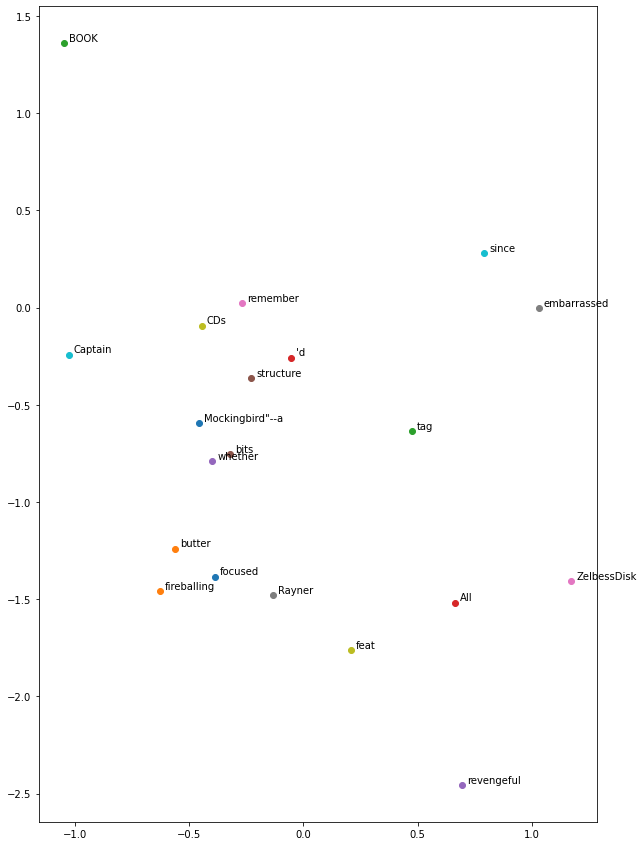

In [18]:
plt.figure(figsize=(10,15))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## Similarity test

In [19]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

In [20]:
def test_senario(a1 , a2) :
    tester1 = get_embed(a1)
    teater2 = get_embed(a2)
    print(f"{a1} similarity to {a2} = {cos_sim(tester1 , teater2)}")

In [22]:
test_senario("Japan","English")
test_senario("Awful","Awful") 
test_senario("gamer","fun") 

Japan similarity to English = -0.05943147820771552
Awful similarity to Awful = 1.0
gamer similarity to fun = 0.6342186981444894
